![JohnSnowLabs](https://sparknlp.org/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp/blob/master/examples/python/llama.cpp/llama.cpp_in_Spark_NLP_AutoGGUFVisionModel.ipynb)

# Import llama.cpp 🦙 vision models into Spark NLP 🚀

Let's keep in mind a few things before we start 😊

- Multimodal inference with llama.cpp was introduced in `Spark NLP 6.0.0`, enabling quantized LLM inference on a wide range of devices. Please make sure you have upgraded to the latest Spark NLP release.
- You need to use your own `.gguf` model files, which also include the models from the [Hugging Face Models](https://huggingface.co/models?library=gguf).- At the moment only CLIP based models are supported.

## Download a GGUF Vision Model

Let's download a GGUF vision model to test it out. For this, we will use [Mozilla/llava-v1.5-7b](https://huggingface.co/Mozilla/llava-v1.5-7b-llamafile/tree/main). It is a 7B parameter model which also is available in 4-bit quantization.

We can download the model and its multimodal projection (mmproj) file by selecting the q4 GGUF file from the "Files and versions" tab.

Once downloaded, we can directly import this model into Spark NLP!

In [ ]:
EXPORT_PATH_MODEL = "llava-v1.5-7b-Q4_K.gguf"
EXPORT_PATH_MMPROJ = "llava-v1.5-7b-mmproj-Q4_0.gguf"
! wget "https://huggingface.co/Mozilla/llava-v1.5-7b-llamafile/resolve/main/{EXPORT_PATH_MODEL}?download=true" -O  {EXPORT_PATH_MODEL}
! wget "https://huggingface.co/Mozilla/llava-v1.5-7b-llamafile/resolve/main/{EXPORT_PATH_MMPROJ}?download=true" -O  {EXPORT_PATH_MMPROJ}

## Import and Save AutoGGUFVisionModel in Spark NLP

- Let's install and setup Spark NLP (if running it Google Colab)
- This part is pretty easy via our simple script

In [ ]:
# Only execute this if you are on Google Colab
! wget -q http://setup.johnsnowlabs.com/colab.sh -O - | bash

Let's start Spark with Spark NLP included via our simple `start()` function

In [ ]:
import sparknlp

# let's start Spark with Spark NLP with GPU enabled. If you don't have GPUs available remove this parameter.
spark = sparknlp.start(gpu=True)
print(sparknlp.version())

- Let's use the `loadSavedModel` function in `AutoGGUFVisionModel`
- Most parameters will be set automatically. They can also be set later after loading the model in `AutoGGUFVisionModel` during runtime, so don't worry about setting them now.
- `loadSavedModel` accepts three parameters: 
  1. the path to the exported gguf model
  1. the path to the exported mmproj gguf model
  2. the SparkSession that is `spark` variable we previously started via `sparknlp.start()`
- NOTE: `loadSavedModel` accepts local paths in addition to distributed file systems such as `HDFS`, `S3`, `DBFS`, etc. This feature was introduced in Spark NLP 4.2.2 release. Keep in mind the best and recommended way to move/share/reuse Spark NLP models is to use `write.save` so you can use `.load()` from any file systems natively.

In [ ]:
from sparknlp.annotator import *

autoGGUFModel = (
    AutoGGUFVisionModel.loadSavedModel(EXPORT_PATH_MODEL, EXPORT_PATH_MMPROJ, spark)
    .setInputCols(["caption_document", "image_assembler"])
    .setOutputCol("completions")
    .setChatTemplate("vicuna")
    .setBatchSize(4)
    .setNGpuLayers(99)
    .setNCtx(4096)
    .setMinKeep(0)
    .setMinP(0.05)
    .setNPredict(40)
    .setNProbs(0)
    .setPenalizeNl(False)
    .setRepeatLastN(256)
    .setRepeatPenalty(1.18)
    .setStopStrings(["</s>", "Llama:", "User:"])
    .setTemperature(0.05)
    .setTfsZ(1)
    .setTypicalP(1)
    .setTopK(40)
    .setTopP(0.95)
)

- Let's save it on disk so it is easier to be moved around and also be used later via `.load` function

In [ ]:
autoGGUFModel.write().overwrite().save(f"llava_v1.5_7b_Q4_0_gguf_spark_nlp")

Awesome  😎 !

This is your GGUF model loaded and saved by Spark NLP 🚀. You can now use it on other machines, clusters, or any place you wish to use your new and shiny GGUF model 😊

In [ ]:
! ls llava_v1.5_7b_Q4_0_gguf_spark_nlp

llava-v1.5-7b-mmproj-Q4_0.gguf	llava-v1.5-7b-Q4_K.gguf  metadata


## Example: Captioning Images

Now let's see how we can use the model to caption some images. Let's first download some images we can caption.

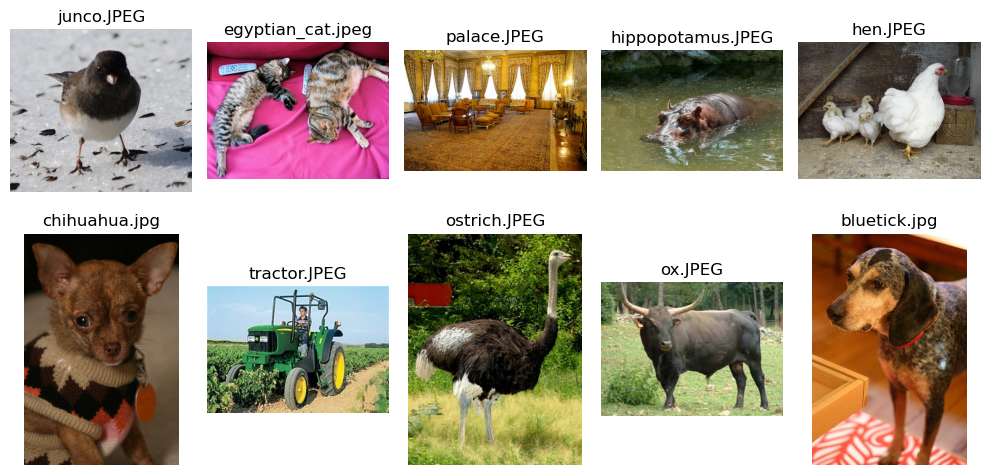

In [ ]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/images.zip
import shutil
shutil.unpack_archive("images.zip", "images", "zip")

from PIL import Image
import matplotlib.pyplot as plt
import os

_, axes = plt.subplots(2, 5, figsize=(10,5))
axes = axes.flatten()

i = 0
images_path = "images/images/"
for file_name in os.listdir(images_path):
    if file_name.lower().endswith((".png", ".jpg", ".jpeg", ".gif")):
        file_path = os.path.join("images/images/", file_name)
        ax = axes[i]
        ax.imshow(Image.open(file_path).convert("RGB"))
        ax.title.set_text(file_name)
        ax.axis("off")
        i += 1

plt.tight_layout()

Now we can load the images to Spark.

**NOTE**: The llama.cpp backend of the annotator expects a different image byte format than the default format used by Spark. This annotator expects *raw* image bytes, instead of the OpenCV image compatible format, which is used by default.

For this, we can use the helper function `loadImagesAsBytes` from the `ImageAssembler`. It will load the images in the right format in a Spark DataFrame. Additionally, we will add a column for the caption:

In [ ]:
from sparknlp.base import *
from pyspark.sql.functions import lit

data = ImageAssembler.loadImagesAsBytes(spark, images_path)
# Add a caption to each image.
data = data.withColumn("caption", lit("Caption this image."))

Now We need an `ImageAssembler` and `DocumentAssembler` to turn the images and captions into the right format for Spark NLP. We also load the model we just saved above. Then we can assemble a pipeline and run it!

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

documentAssembler = (
    DocumentAssembler().setInputCol("caption").setOutputCol("caption_document")
)
imageAssembler = ImageAssembler().setInputCol("image").setOutputCol("image_assembler")
model = AutoGGUFVisionModel.load("llava_v1.5_7b_Q4_0_gguf_spark_nlp")
pipeline = Pipeline().setStages([documentAssembler, imageAssembler, model])

pipeline.fit(data).transform(data).selectExpr(
    "reverse(split(image.origin, '/'))[0] as image_name", "completions.result"
).show(truncate=False)

25/01/18 13:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1090.9 KiB
clip_model_load: model name:   openai/clip-vit-large-patch14-336    (0 + 1) / 1]
clip_model_load: description:  image encoder for LLaVA
clip_model_load: GGUF version: 3
clip_model_load: alignment:    32
clip_model_load: n_tensors:    377
clip_model_load: n_kv:         19
clip_model_load: ftype:        q4_0

clip_model_load: loaded meta data with 19 key-value pairs and 377 tensors from /tmp/spark-5acddb2b-4bca-474e-befd-d8613d27a78e/userFiles-4926735e-f265-46bc-8a9f-9edb6a65484e/llava-v1.5-7b-mmproj-Q4_0.gguf
clip_model_load: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
clip_model_load: - kv   0:                       general.architecture str              = clip
clip_model_load: - kv   1:                      clip.has_text_encoder bool             = false
clip_model_load: - kv   2:                    clip.has_vision_encoder bool             = true
clip_model_load: - 

[INFO] build info build=3534 commit="641f5dd2"
[INFO] system info n_threads=6 n_threads_batch=-1 total_threads=6 system_info="AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | AVX512_BF16 = 0 | FMA = 1 | NEON = 0 | SVE = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | LLAMAFILE = 1 | "
[INFO] Multi Modal Mode Enabled


key clip.vision.image_grid_pinpoints not found in file
key clip.vision.mm_patch_merge_type not found in file
key clip.vision.image_crop_resolution not found in file
ggml_gallocr_reserve_n: reallocating CUDA0 buffer from size 0.00 MiB to 32.89 MiB
clip_model_load: compute allocated memory: 32.89 MB
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /tmp/spark-5acddb2b-4bca-474e-befd-d8613d27a78e/userFiles-4926735e-f265-46bc-8a9f-9edb6a65484e/llava-v1.5-7b-Q4_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32   

[INFO] initializing slots n_slots=1
[INFO] new slot slot_id=0 n_ctx_slot=4096
[INFO] model loaded
[INFO] chat template chat_example="You are a helpful assistant\n\nUSER: Hello\nASSISTANT: Hi there</s>\nUSER: How are you?\nASSISTANT:" built_in=false
[INFO] all slots are idle and system prompt is empty, clear the KV cache
[INFO] slot is processing task slot_id=0 task_id=0
[INFO] kv cache rm [p0, end) slot_id=0 task_id=0 p0=0


encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    76.17 ms by CLIP (    0.13 ms per image patch)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
llama_output_reserve: reallocating output buffer from size 0.12 MiB to 1.22 MiB
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)


[INFO] prompt eval time     =     481.17 ms /     1 tokens (  481.17 ms per token,     2.08 tokens per second) slot_id=0 task_id=0 t_prompt_processing=481.165 n_prompt_tokens_processed=1 t_token=481.165 n_tokens_second=2.078289152369769
[INFO] generation eval time =     757.27 ms /    40 runs   (   18.93 ms per token,    52.82 tokens per second) slot_id=0 task_id=0 t_token_generation=757.271 n_decoded=40 t_token=18.931775 n_tokens_second=52.821248932020374
[INFO]           total time =    1238.44 ms slot_id=0 task_id=0 t_prompt_processing=481.165 t_token_generation=757.271 t_total=1238.436
[INFO] slot released slot_id=0 task_id=0 n_ctx=4096 n_past=632 n_system_tokens=0 n_cache_tokens=41 truncated=false
[INFO] slot is processing task slot_id=0 task_id=1
[INFO] kv cache rm [p0, end) slot_id=0 task_id=1 p0=0


encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    48.94 ms by CLIP (    0.08 ms per image patch)
ggml_gallocr_needs_realloc: node inp_embd is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)


[INFO] prompt eval time     =     418.86 ms /     1 tokens (  418.86 ms per token,     2.39 tokens per second) slot_id=0 task_id=1 t_prompt_processing=418.858 n_prompt_tokens_processed=1 t_token=418.858 n_tokens_second=2.387443954753162
[INFO] generation eval time =     760.78 ms /    40 runs   (   19.02 ms per token,    52.58 tokens per second) slot_id=0 task_id=1 t_token_generation=760.785 n_decoded=40 t_token=19.019624999999998 n_tokens_second=52.57727215967718
[INFO]           total time =    1179.64 ms slot_id=0 task_id=1 t_prompt_processing=418.858 t_token_generation=760.785 t_total=1179.643
[INFO] slot released slot_id=0 task_id=1 n_ctx=4096 n_past=632 n_system_tokens=0 n_cache_tokens=41 truncated=false


25/01/18 13:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1090.9 KiB


[INFO] slot is processing task slot_id=0 task_id=84
[INFO] kv cache rm [p0, end) slot_id=0 task_id=84 p0=0


encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    51.93 ms by CLIP (    0.09 ms per image patch)
ggml_gallocr_needs_realloc: node inp_embd is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)


[INFO] prompt eval time     =     434.93 ms /     1 tokens (  434.93 ms per token,     2.30 tokens per second) slot_id=0 task_id=84 t_prompt_processing=434.926 n_prompt_tokens_processed=1 t_token=434.926 n_tokens_second=2.2992417100840146
[INFO] generation eval time =     759.00 ms /    40 runs   (   18.98 ms per token,    52.70 tokens per second) slot_id=0 task_id=84 t_token_generation=759.003 n_decoded=40 t_token=18.975075 n_tokens_second=52.70071396292241
[INFO]           total time =    1193.93 ms slot_id=0 task_id=84 t_prompt_processing=434.926 t_token_generation=759.003 t_total=1193.929
[INFO] slot released slot_id=0 task_id=84 n_ctx=4096 n_past=632 n_system_tokens=0 n_cache_tokens=41 truncated=false
[INFO] slot is processing task slot_id=0 task_id=85
[INFO] kv cache rm [p0, end) slot_id=0 task_id=85 p0=0


encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    49.35 ms by CLIP (    0.09 ms per image patch)
ggml_gallocr_needs_realloc: node inp_embd is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)
encode_image_with_clip: image embedding created: 576 tokens         (1 + 3) / 4]

encode_image_with_clip: image encoded in    50.33 ms by CLIP (    0.0

[INFO] prompt eval time     =     418.23 ms /     1 tokens (  418.23 ms per token,     2.39 tokens per second) slot_id=0 task_id=85 t_prompt_processing=418.234 n_prompt_tokens_processed=1 t_token=418.234 n_tokens_second=2.391005991861016
[INFO] generation eval time =     310.67 ms /    17 runs   (   18.27 ms per token,    54.72 tokens per second) slot_id=0 task_id=85 t_token_generation=310.665 n_decoded=17 t_token=18.274411764705885 n_tokens_second=54.72132361225113
[INFO]           total time =     728.90 ms slot_id=0 task_id=85 t_prompt_processing=418.234 t_token_generation=310.665 t_total=728.899
[INFO] slot released slot_id=0 task_id=85 n_ctx=4096 n_past=609 n_system_tokens=0 n_cache_tokens=18 truncated=false
[INFO] slot is processing task slot_id=0 task_id=87
[INFO] kv cache rm [p0, end) slot_id=0 task_id=87 p0=0


ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)


[INFO] prompt eval time     =     423.11 ms /     1 tokens (  423.11 ms per token,     2.36 tokens per second) slot_id=0 task_id=87 t_prompt_processing=423.106 n_prompt_tokens_processed=1 t_token=423.106 n_tokens_second=2.3634739285190944
[INFO] generation eval time =     771.11 ms /    40 runs   (   19.28 ms per token,    51.87 tokens per second) slot_id=0 task_id=87 t_token_generation=771.106 n_decoded=40 t_token=19.27765 n_tokens_second=51.873542677660396
[INFO]           total time =    1194.21 ms slot_id=0 task_id=87 t_prompt_processing=423.106 t_token_generation=771.106 t_total=1194.212
[INFO] slot released slot_id=0 task_id=87 n_ctx=4096 n_past=632 n_system_tokens=0 n_cache_tokens=41 truncated=false
[INFO] slot is processing task slot_id=0 task_id=88
[INFO] kv cache rm [p0, end) slot_id=0 task_id=88 p0=0


encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    50.07 ms by CLIP (    0.09 ms per image patch)
ggml_gallocr_needs_realloc: node inp_embd is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)


[INFO] prompt eval time     =     423.79 ms /     1 tokens (  423.79 ms per token,     2.36 tokens per second) slot_id=0 task_id=88 t_prompt_processing=423.79 n_prompt_tokens_processed=1 t_token=423.79 n_tokens_second=2.359659265202105
[INFO] generation eval time =     251.86 ms /    14 runs   (   17.99 ms per token,    55.59 tokens per second) slot_id=0 task_id=88 t_token_generation=251.863 n_decoded=14 t_token=17.990214285714284 n_tokens_second=55.58577480614461
[INFO]           total time =     675.65 ms slot_id=0 task_id=88 t_prompt_processing=423.79 t_token_generation=251.863 t_total=675.653
[INFO] slot released slot_id=0 task_id=88 n_ctx=4096 n_past=606 n_system_tokens=0 n_cache_tokens=15 truncated=false
[INFO] slot is processing task slot_id=0 task_id=89
[INFO] kv cache rm [p0, end) slot_id=0 task_id=89 p0=0


encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    49.78 ms by CLIP (    0.09 ms per image patch)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)
encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    50.26 ms by CLIP (    0.09 ms per image patch)
ggml_gallocr_needs_realloc: node inp_embd is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)

[INFO] prompt eval time     =     422.05 ms /     1 tokens (  422.05 ms per token,     2.37 tokens per second) slot_id=0 task_id=89 t_prompt_processing=422.047 n_prompt_tokens_processed=1 t_token=422.047 n_tokens_second=2.369404355439086
[INFO] generation eval time =     351.31 ms /    19 runs   (   18.49 ms per token,    54.08 tokens per second) slot_id=0 task_id=89 t_token_generation=351.31 n_decoded=19 t_token=18.49 n_tokens_second=54.08328826392644
[INFO]           total time =     773.36 ms slot_id=0 task_id=89 t_prompt_processing=422.047 t_token_generation=351.31 t_total=773.357
[INFO] slot released slot_id=0 task_id=89 n_ctx=4096 n_past=611 n_system_tokens=0 n_cache_tokens=20 truncated=false
[INFO] slot is processing task slot_id=0 task_id=90
[INFO] kv cache rm [p0, end) slot_id=0 task_id=90 p0=0


ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)


[INFO] prompt eval time     =     419.07 ms /     1 tokens (  419.07 ms per token,     2.39 tokens per second) slot_id=0 task_id=90 t_prompt_processing=419.071 n_prompt_tokens_processed=1 t_token=419.071 n_tokens_second=2.386230495548487
[INFO] generation eval time =     768.85 ms /    40 runs   (   19.22 ms per token,    52.03 tokens per second) slot_id=0 task_id=90 t_token_generation=768.849 n_decoded=40 t_token=19.221225 n_tokens_second=52.0258204146718
[INFO]           total time =    1187.92 ms slot_id=0 task_id=90 t_prompt_processing=419.071 t_token_generation=768.849 t_total=1187.92
[INFO] slot released slot_id=0 task_id=90 n_ctx=4096 n_past=632 n_system_tokens=0 n_cache_tokens=41 truncated=false
[INFO] slot is processing task slot_id=0 task_id=91
[INFO] kv cache rm [p0, end) slot_id=0 task_id=91 p0=0


encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    49.82 ms by CLIP (    0.09 ms per image patch)
ggml_gallocr_needs_realloc: node inp_embd is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)


[INFO] prompt eval time     =     424.45 ms /     1 tokens (  424.45 ms per token,     2.36 tokens per second) slot_id=0 task_id=91 t_prompt_processing=424.45 n_prompt_tokens_processed=1 t_token=424.45 n_tokens_second=2.3559901048415597
[INFO] generation eval time =     761.95 ms /    40 runs   (   19.05 ms per token,    52.50 tokens per second) slot_id=0 task_id=91 t_token_generation=761.953 n_decoded=40 t_token=19.048825 n_tokens_second=52.49667630418149
[INFO]           total time =    1186.40 ms slot_id=0 task_id=91 t_prompt_processing=424.45 t_token_generation=761.953 t_total=1186.403
[INFO] slot released slot_id=0 task_id=91 n_ctx=4096 n_past=632 n_system_tokens=0 n_cache_tokens=41 truncated=false
[INFO] slot is processing task slot_id=0 task_id=92
[INFO] kv cache rm [p0, end) slot_id=0 task_id=92 p0=0


encode_image_with_clip: image embedding created: 576 tokens

encode_image_with_clip: image encoded in    49.04 ms by CLIP (    0.09 ms per image patch)
ggml_gallocr_needs_realloc: node inp_embd is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 1)


[INFO] prompt eval time     =     417.26 ms /     1 tokens (  417.26 ms per token,     2.40 tokens per second) slot_id=0 task_id=92 t_prompt_processing=417.263 n_prompt_tokens_processed=1 t_token=417.263 n_tokens_second=2.3965700289745318
[INFO] generation eval time =     329.49 ms /    18 runs   (   18.31 ms per token,    54.63 tokens per second) slot_id=0 task_id=92 t_token_generation=329.493 n_decoded=18 t_token=18.305166666666665 n_tokens_second=54.629385146270174
[INFO]           total time =     746.76 ms slot_id=0 task_id=92 t_prompt_processing=417.263 t_token_generation=329.493 t_total=746.756
[INFO] slot released slot_id=0 task_id=92 n_ctx=4096 n_past=610 n_system_tokens=0 n_cache_tokens=19 truncated=false
+-----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|image_name       |result                                     

ggml_gallocr_needs_realloc: src 0 (KQ_mask) of node KQ_mask (view) is not valid
ggml_gallocr_alloc_graph: cannot reallocate multi buffer graph automatically, call reserve
ggml_backend_sched_alloc_splits: failed to allocate graph, reserving (backend_ids_changed = 0)


That's it! You can now go wild and use hundreds of GGUF models from HuggingFace 🤗 in Spark NLP 🚀
